## Overall Prediction Observation


In [13]:
# Define variables
IS_FILTERED = True
ARCHIVED = None

SHOW_HEADER = True
SHOW_LAST_APPEARANCE = 150

In [14]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Define functions
def compute_rmse(actual, predicted):
    return np.sqrt(((actual - predicted) ** 2).mean())

def compute_mape(actual, predicted):
    return 100 * np.mean(np.abs((actual - predicted) / actual))

def compute_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def load_data(layer: str, datafile: str, archived: int = None, last_appearance: int = None):
    dir = (
        "../source/" + layer + "_prediction_dataset/" + datafile
        if archived is None
        else "../source/"
        + layer
        + "_prediction_dataset/archive/"
        + str(archived)
        + "/"
        + datafile
    )
    df = pd.read_csv(dir)
    df["Time"] = pd.to_datetime(df["Time"])
    df["FormattedTime"] = df["Time"].dt.strftime("%H:%M:%S")
    df = df.sort_values(by="FormattedTime")
    df = df.set_index("FormattedTime")
    # Reduce size of appearance
    if last_appearance is not None: df = df.tail(last_appearance)
    return df

In [16]:
# Load data
datafile = "prediction_result_filtered.csv" if IS_FILTERED else "prediction_result.csv"
dir = "../source/"

dfs = {
    "l1": load_data("l1", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE),
    "l2": load_data("l2", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE),
    "l3": load_data("l3", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE),
}

# Indicate which columns to ignore
IGNORED_COLS = ["Time", "Actual"] # No need to include "FormattedTime" because it is used as index
if IS_FILTERED: IGNORED_COLS.append("Raw")

In [17]:
# Compute RMSE, MAE, and MAPE for each model
for key, df in dfs.items():
    print("Layer", key)
    for column in df.columns:
        if column not in IGNORED_COLS:
            actual = df["Raw"] if IS_FILTERED else df["Actual"]
            rmse = compute_rmse(actual, df[column])
            mape = compute_mape(actual, df[column])
            mae = compute_mae(actual, df[column])
            print(f"{column} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    print("------------------")

Layer l1
ARIMA - RMSE: 0.0914, MAE: 0.0636, MAPE: 49.80%
SARIMA - RMSE: 0.0984, MAE: 0.0684, MAPE: 52.64%
ETS - RMSE: 0.1178, MAE: 0.0813, MAPE: 63.33%
GP - RMSE: 0.1418, MAE: 0.0925, MAPE: 65.83%
LSTM - RMSE: 0.0631, MAE: 0.0466, MAPE: 35.02%
CNN - RMSE: 0.0656, MAE: 0.0486, MAPE: 36.83%
GRU - RMSE: 0.0614, MAE: 0.0453, MAPE: 34.42%
TCN - RMSE: 0.0689, MAE: 0.0531, MAPE: 40.72%
------------------
Layer l2
LINEAR_REGRESSION - RMSE: 0.0594, MAE: 0.0436, MAPE: 32.27%
RANDOM_FOREST - RMSE: 0.0622, MAE: 0.0458, MAPE: 35.63%
FEEDFORWARD_NEURAL_NETWORK - RMSE: 0.0610, MAE: 0.0438, MAPE: 32.81%
------------------
Layer l3
Predicted - RMSE: 0.0601, MAE: 0.0438, MAPE: 33.11%
------------------


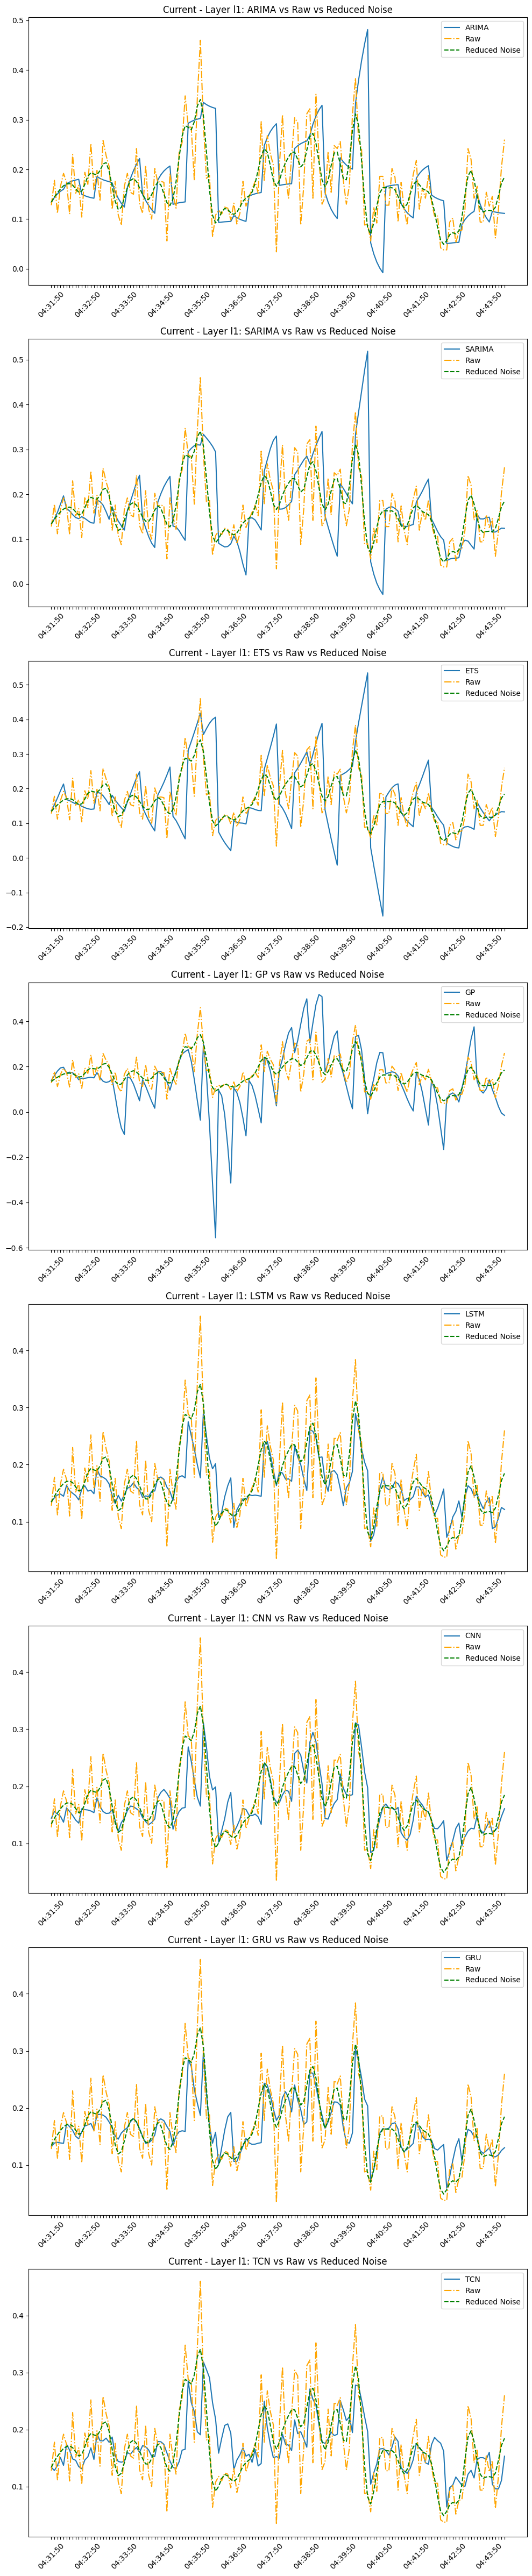

------------------


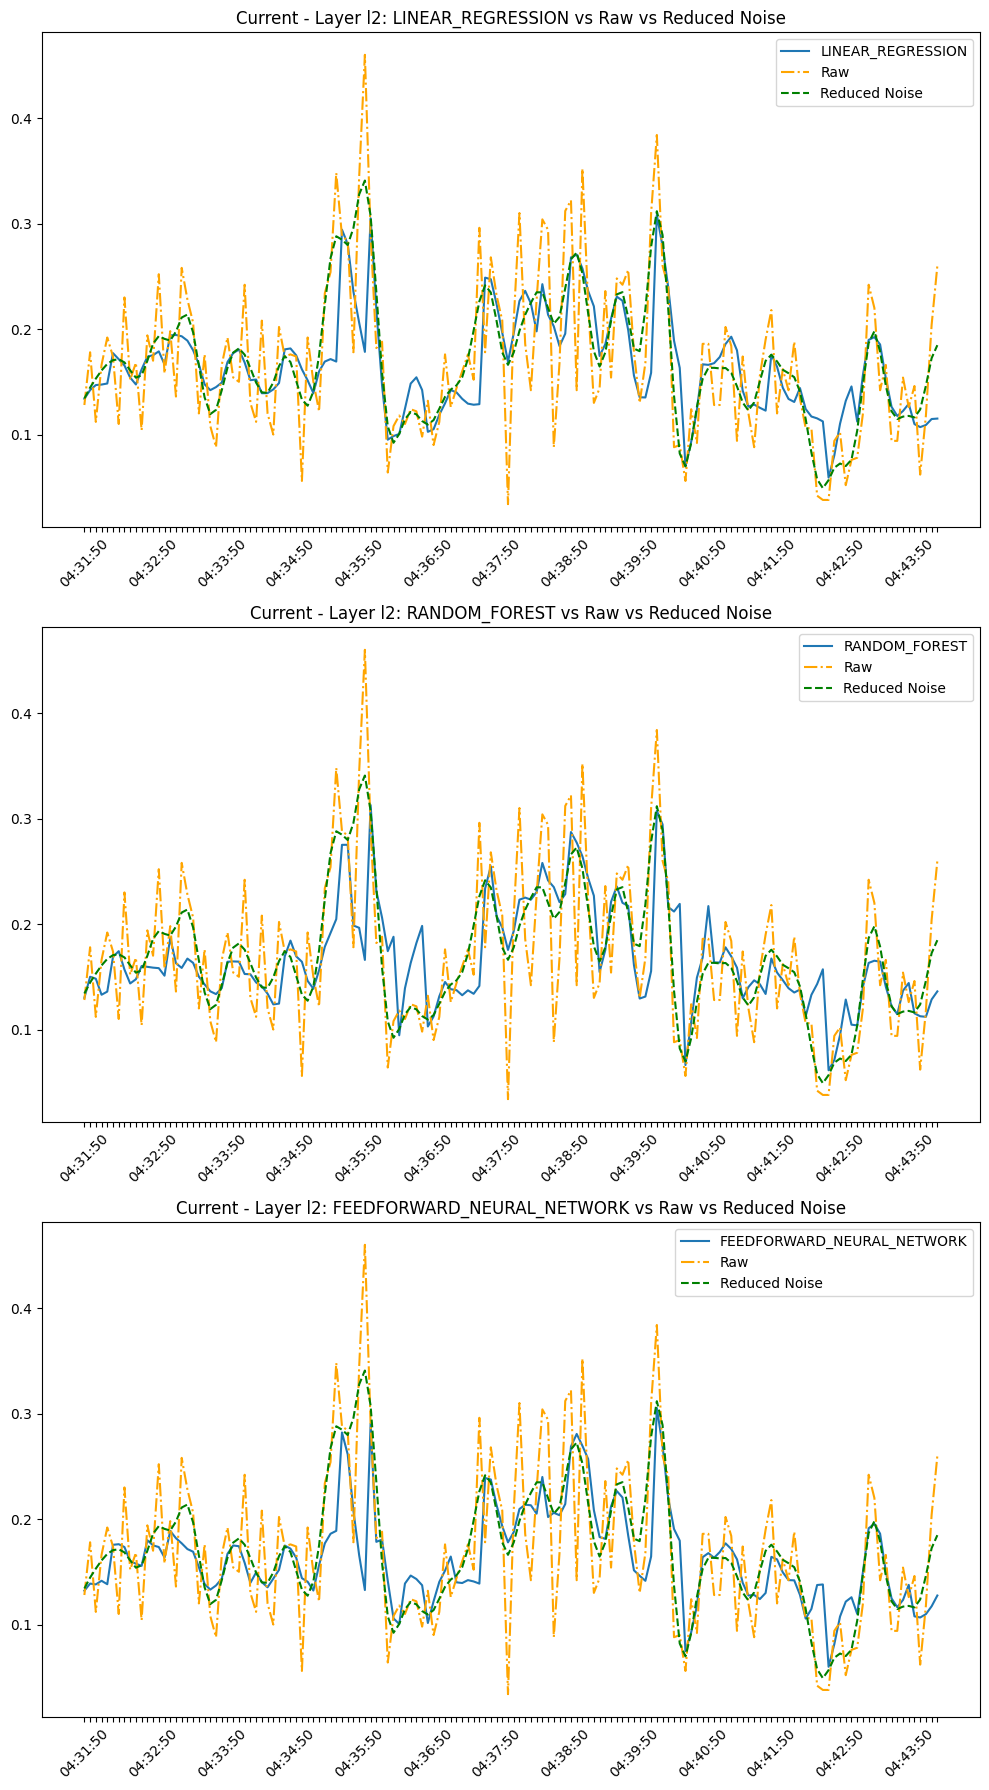

------------------


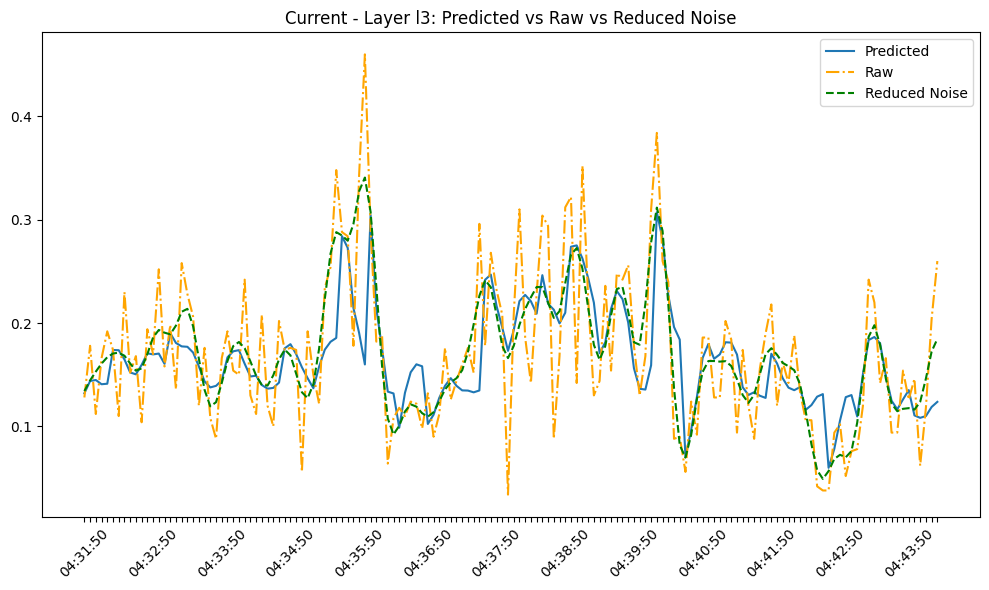

------------------


In [18]:
# Plot the data
header = (str(ARCHIVED) if ARCHIVED is not None else "Current") + " - "
header = header if SHOW_HEADER else ""

for key, df in dfs.items():
    # Plot the data
    fig, axes = plt.subplots(
        nrows=len(df.columns) - len(IGNORED_COLS),
        figsize=(10, 6 * (len(df.columns) - len(IGNORED_COLS))),
    )

    # Ensure axes is always a list or array
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    ax_idx = 0  # Separate index for accessing axes

    for column in df.columns:
        if column not in IGNORED_COLS:
            actual_label = "Reduced Noise" if IS_FILTERED else "Raw"
            actual_color = "green" if IS_FILTERED else "orange"
            axes[ax_idx].plot(df.index, df[column], label=column)
            if IS_FILTERED:
                axes[ax_idx].plot(
                    df.index,
                    df["Raw"],
                    label="Raw",
                    linestyle="-.",
                    color="orange",
                )  # Added this line to plot the Raw values
            axes[ax_idx].plot(
                df.index,
                df["Actual"],
                label=actual_label,
                linestyle="--",
                color=actual_color,
            )

            # Sparse Tick Labels logic
            n = 12  # Display every n-th label
            for index, label in enumerate(axes[ax_idx].xaxis.get_ticklabels()):
                if index % n != 0:
                    label.set_visible(False)

            # Rotate the visible x-axis labels
            axes[ax_idx].tick_params(axis="x", rotation=45)

            axes[ax_idx].legend()
            # axes[ax_idx].grid(True) # Uncomment this line to show grid lines
            title = f"{header}Layer {key}: {column} vs Raw"
            if IS_FILTERED:
                title += " vs Reduced Noise"
            axes[ax_idx].set_title(title)
            ax_idx += 1  # Increment ax_idx

    plt.tight_layout()
    plt.show()
    print("------------------")